In [37]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import automin.autodiff.variables as v
import automin.autodiff.AD_numpy as anp
import automin.autodiff.vector_variables as vv
import automin.optimizer as op
import automin.evaluate as evaluate


# AutoMin: An Optimization Package Using Automatic Differentiation

## Group 5: Team Non-CS Majors

### Eric Choi, Josh Feldman, Yuting Kou, Shane Ong

## Motivation

Taking derivatives is an essential operation in numerical methods, optimization, and science. From a computational perspective, however, calculating a derivative can be difficult.

**Finite Differences** requires careful selection of $\epsilon$

**Symbolic Differentiation** is infeasible for complicated functions, especially for higher order derivatives

## Motivation

**Automatic Differentiation** overcomes these challenges by providing both quick and accurate derivatives.

This also allows us to provide optimization methods that are fast and accurate. Most of the standard optimization modules such as `scipy.optimize` do not rely on automatic differentiation. 

### Brief Mathematical Background 

![](figs/background.png)
$
y = x^2 + 1 \\ 
z = \frac{1}{y} \\
$

 We would like to obtain 
$
\frac{\partial z}{\partial x}
$
by using the chain rule:

$
\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} * \frac{\partial y}{\partial x}
$


![](figs/background.png)
$
y = x^2 + 1 \\ 
z = \frac{1}{y} \\
$

In this case, 

$
\frac{\partial z}{\partial y} = -\frac{1}{y^2} = -\frac{1}{(x^2+1)^2} \\
\frac{\partial y}{\partial x} = 2x
$

![](figs/background.png)
$
\frac{\partial z}{\partial y} = -\frac{1}{y^2} = -\frac{1}{(x^2+1)^2} \\
\frac{\partial y}{\partial x} = 2x
$

Therefore, 

$
\frac{\partial z}{\partial x} \\
= \frac{\partial z}{\partial y} * \frac{\partial y}{\partial x} \\ 
= -\frac{2x}{(x^2+1)^2}
$

### Demo for AD module

The user provides a function...

In [4]:
f1 = lambda x, y: anp.exp(3*x) + anp.log(y/x)

...the user can calculate its value...

In [5]:
f1(2, 3)

403.83425860084327

...but now the user wishes to get its derivative

In [6]:
a = v.Variable('a', 2)
b = v.Variable('b', 3)
res1 = f1(a,b)
res1

Variable name: f(b,a), Value: 403.83425860084327, Derivatives: {'b': 0.3333333333333333, 'a': 1209.7863804782053}

### Demo for AD module

Similarly, if the user has a vector function...

In [7]:
@vv.vectorize_variable
def vec_fn(x, y, z):
    f1 = x * y + anp.sin(y) + anp.cos(z)
    f2 = x + y + anp.sin(x*y)
    return np.array([f1,f2])

...the user can extract the values, jacobian, and partial derivatives.

In [8]:
c = v.Variable('c', 2)
res2 = vec_fn(a, b, c)

In [9]:
res2

f0: Variable name: f(b,c,a), Value: 5.724973171512725, Derivatives: {'b': 1.0100075033995546, 'c': -0.9092974268256817, 'a': 3}
f1: Variable name: f(b,a), Value: 4.720584501801074, Derivatives: {'b': 2.9203405733007317, 'a': 3.880510859951098}

In [10]:
print('Value: {}.'.format(res2.val))
print('Partial Derivative wrt a: {}'.format(res2.partial_der(a)))
display(res2.jacobian())

Value: [5.72497317 4.7205845 ].
Partial Derivative wrt a: [3.         3.88051086]


,a,b,c
0,3.000000,1.010008,-0.909297
1,3.880511,2.920341,0.000000


### Now all that seems trivial. 

When would a user just want to solely calculate the gradient of a function?

#### Instead, suppose a user wants to find the root of a given function using Newton's method

In [11]:
def newton_method_scalar(fn, x, threshold, max_iter, verbose=True, norm=2):
    
    var_names = ['x'+str(idx) for idx in range(len(x))]
    
    x = np.array(x)
    nums_iteration = 0
    while True:
        x_new = x - fn(*x) / get_grad(fn, x, var_names)

        # print iteration output
        if verbose is True:
            print(f'Iteration at {nums_iteration}, at {x} ')
        
        # threshold stopping condition 
        if np.linalg.norm(x-x_new, norm) < threshold:
            print(f'After {nums_iteration} iterations, found a root: {x_new}')
            break
        
        # iteration stopping condition
        if nums_iteration >= max_iter:
            break
        nums_iteration +=1
        x = x_new
        
def get_grad(fn, x, var_names):
    variables = [v.Variable(var_names[idx], x_n) for idx, x_n in enumerate(x)]
    out = fn(*variables)
    jacobian = out.jacobian()
    grad = np.array([jacobian[name] for name in var_names])
    return grad

### Newton's Method

In [12]:
f2 = lambda x, y, z: (x-4)**2 + (y-3)**2 + (z-2)**2
newton_method_scalar(f2, [3, 2, 1], 1e-6, 50, verbose=True)

Iteration at 0, at [3 2 1] 
Iteration at 1, at [4.5 3.5 2.5] 
Iteration at 2, at [3.75 2.75 1.75] 
Iteration at 3, at [4.125 3.125 2.125] 
Iteration at 4, at [3.9375 2.9375 1.9375] 
Iteration at 5, at [4.03125 3.03125 2.03125] 
Iteration at 6, at [3.984375 2.984375 1.984375] 
Iteration at 7, at [4.0078125 3.0078125 2.0078125] 
Iteration at 8, at [3.99609375 2.99609375 1.99609375] 
Iteration at 9, at [4.00195312 3.00195312 2.00195312] 
Iteration at 10, at [3.99902344 2.99902344 1.99902344] 
Iteration at 11, at [4.00048828 3.00048828 2.00048828] 
Iteration at 12, at [3.99975586 2.99975586 1.99975586] 
Iteration at 13, at [4.00012207 3.00012207 2.00012207] 
Iteration at 14, at [3.99993896 2.99993896 1.99993896] 
Iteration at 15, at [4.00003052 3.00003052 2.00003052] 
Iteration at 16, at [3.99998474 2.99998474 1.99998474] 
Iteration at 17, at [4.00000763 3.00000763 2.00000763] 
Iteration at 18, at [3.99999619 2.99999619 1.99999619] 
Iteration at 19, at [4.00000191 3.00000191 2.00000191] 
I

**It is relatively simple to write up code for algorithms requiring first-order derivatives!**

**A common class of problems requiring derivatives is optimization**

As such, we decided to use our AD module as a basis for an optimization package!

### Optimization

Generally, optimization is to find the 'best available' values of an objective function given a defined domain

**Simply, optimization can be thought of as maximizing (or minimizing) a real function**

Our optimization module thus seeks to provide users a way to minimize functions. We have implemented 4 first-order iterative algorithms to minimize a function.

### Optimization

1. Gradient Descent

2. Steepest Descent

3. Conjugate Gradient 

4. Broyden-Fletcher-Goldfarb-Shanno (BFGS) 

5. Stochastic Gradient Descent

### Gradient Descent

Gradient descent is the simplest first-order iterative algorithm but introduces a key idea that forms the basis of iterative algorithms. 

**Notice that if we walk in the negative direction of the gradient, it seems like we will eventually reach the minimum**

### Gradient Descent

Mathematically, for a function $\ell(x)$ this is saying that to move from $x^{(t)}$ to $x^{(t+1)}$, we should follow the path of steepest descent $-\nabla\ell(x^{(t)})$

If we do this over and over again ...

![](figs/gradient-descent.png)

In [39]:
f=lambda x,y:x**2+(y-1)**2
res_GD=op.minimize(f,[-1,-1],method="Gradient Descent",precision=1e-5)
res_GD.x

array([-2.23556770e-06,  9.99995529e-01])

### It is clear that we will eventually reach the local minimum for most cases!

### However, an even better method would be to update the direction with each step

This will allow us to pick favorable directions that take better steps or to pick 'non-interfering' directions

### Steepest Descent

Steepest descent chooses a new direction through a line minimzation along a direction $s$, before moving along a new direction $-\nabla f$. 

![steepestdescent.png](figs/steepestdescent.png)

### This basically means that steepest descent is picking a new direction that is orthogonal to the previous direction


![descent.png](figs/descent.png)

In [40]:
res_SD=op.minimize(f,[-1,-1],method="Steepest Descent",precision=1e-5)
res_SD.x

array([3.55271368e-15, 1.00000000e+00])

### Conjugate Gradient

After the line minimization along a direction $u$, instead of moving along a direction $v = -\nabla f$ which is the direction of steepest descent, we can instead perturb the direction to ensure that $\nabla f$ is perpendicular to the line minimization direction $u$ before and after we move along the perturbed direction.

![](figs/conjugategradient.jpg)

**This ensures that the conjugate gradient method moves in non-interfering directions**

In steepest descent, we only make right angle turns. Each step is along directions that can undo the minimization in the previous step. As such, we might take some time before it reaches the minimum. This is often the case in practice.

Conjugate gradient instead uses conjugate directions which preserve the minimization achieved in the previous step. 

![](figs/descent.png)

In [41]:
res_CG=op.minimize(f,[-1,-1],method="Conjugate Gradient",precision=1e-5)
res_CG.x

array([2.24820162e-15, 1.00000000e+00])

### BFGS

![](figs/bfgs.jpg)

In [42]:
res_BFGS=op.minimize(f,[-1,-1],method="BFGS",precision=1e-5)
res_BFGS.x

array([-2.22044605e-16,  1.00000000e+00])

### Demo for four optimizers


##### Vector Function
Let's test the function:
$$f_1=100(y-x^2)^2 + (1-x)^2$$

And it reaches minimum at $[1,1]$

In [43]:
f1=lambda x, y : 100*(y-x**2)**2 + (1-x)**2
v0_list = [[-5,5], [5,5], [5,-5]]
models=['Conjugate Gradient','Steepest Descent','BFGS','Gradient Descent']
x_grid = np.linspace(-10, 10, 500)
y_grid = np.linspace(-10, 10, 500)

In [44]:
res={}
for model in models:
    res[model]=[op.minimize(f1,v0,method=model,max_iter=100000,lr=1e-5,sigma=1e-5,precision=1e-5) for v0 in v0_list]

C:\Users\Lenovo\Desktop\cs207_FinalProject\automin\optimizer.py:36: UserWarning: optimization did not converge
  warnings.warn("optimization did not converge")


**Gradient Descent**


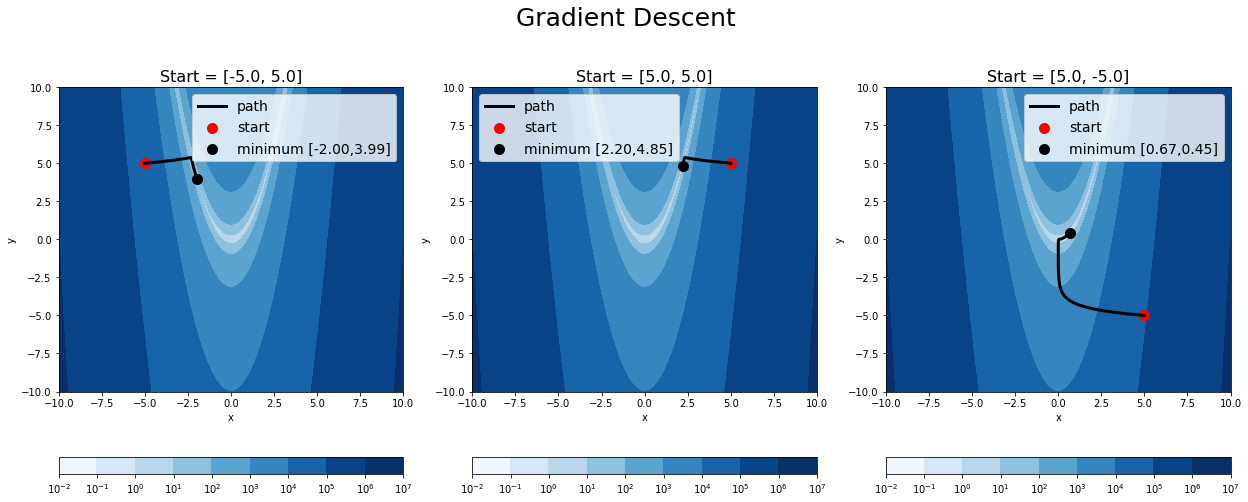

In [45]:
evaluate.plot_path(f1, res['Gradient Descent'], 'Gradient Descent', x_grid=x_grid, y_grid=y_grid)

it converges so slow that requires more than 100000 to converge! 

**Conjugate Gradient and Steepest Descent**

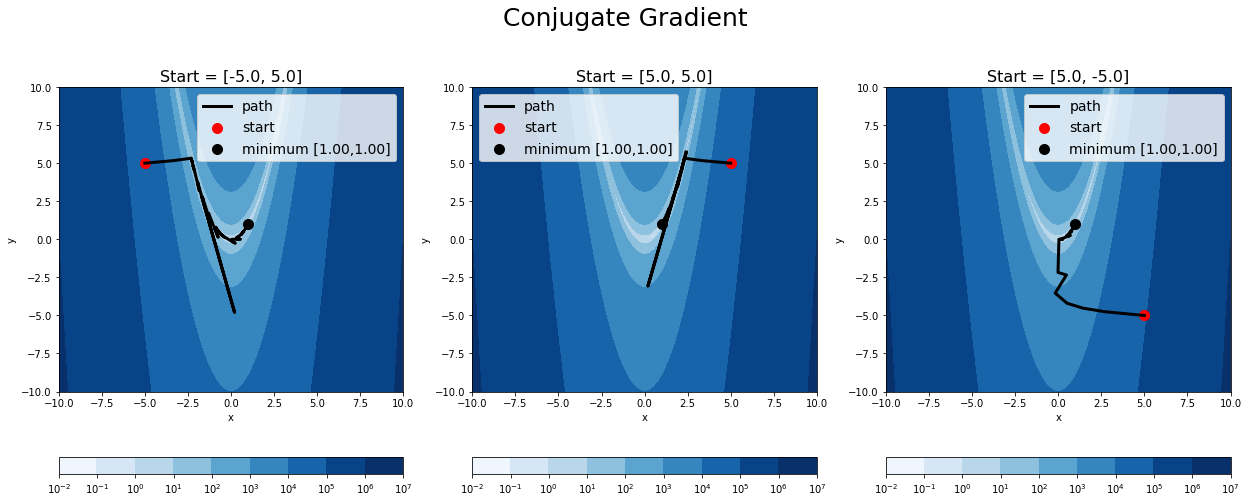

In [46]:
evaluate.plot_path(f1, res['Conjugate Gradient'], 'Conjugate Gradient', x_grid=x_grid, y_grid=y_grid)

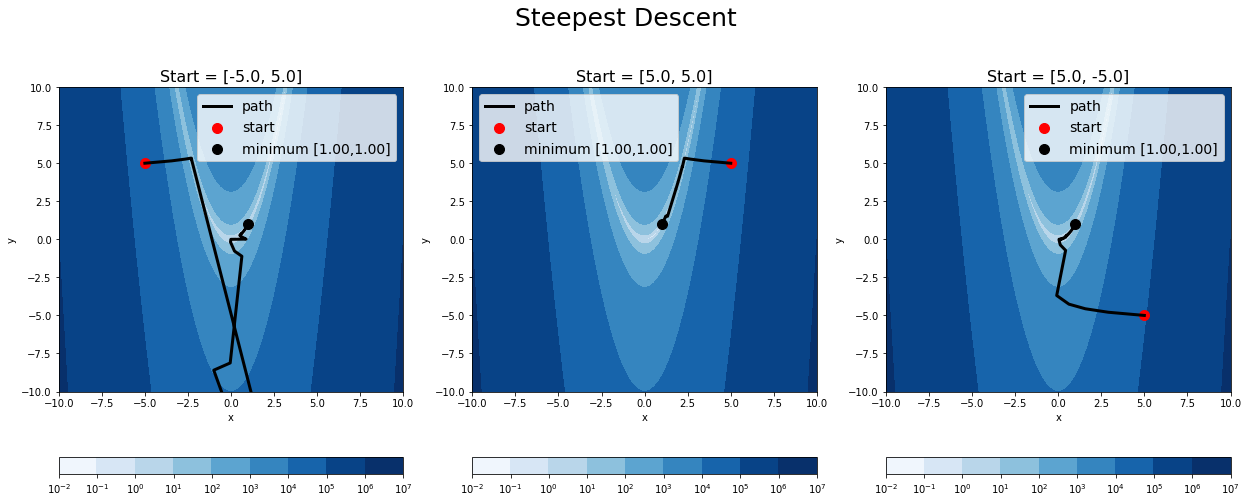

In [47]:
evaluate.plot_path(f1, res['Steepest Descent'], 'Steepest Descent', x_grid=x_grid, y_grid=y_grid)

**BFGS**

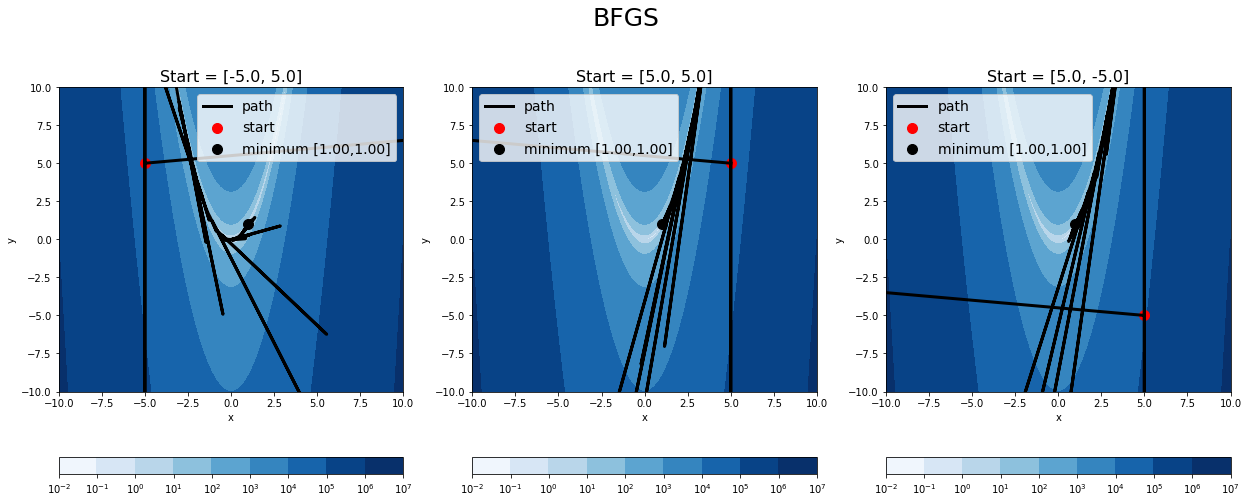

In [48]:
evaluate.plot_path(f1, res['BFGS'], 'BFGS', x_grid=x_grid, y_grid=y_grid)

**Optimizer Performance**

We measure its convergence time and accuracy rate each iterations, and compare with `scipy.optimize.minimize` corresponding method.

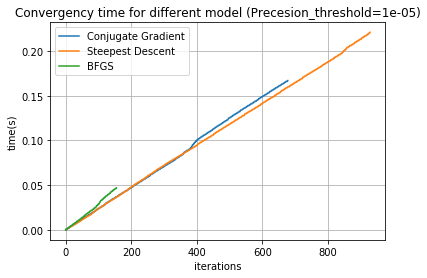

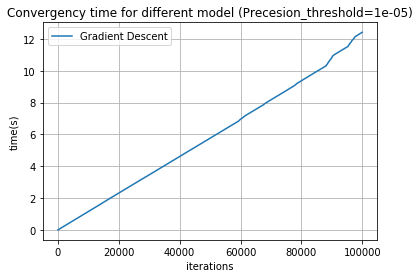

In [49]:
evaluate.plot_convergency(res,i=-1)

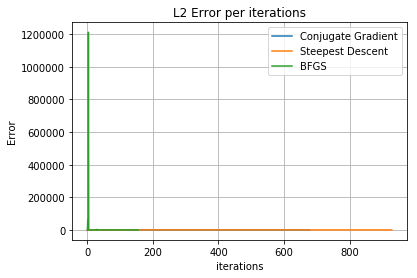

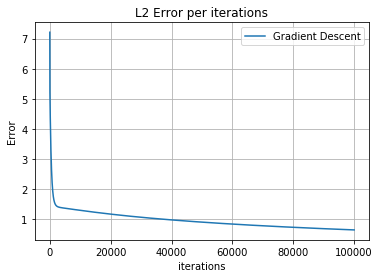

In [50]:
evaluate.plot_accuracy(res,[1,1],i=-1)

### Let's compare with scipy's optimization module

In [51]:
from scipy.optimize import minimize 
for model in ['BFGS','CG']:
    res['scipy_'+model]=[minimize(lambda x:f1(*x),v0,method=model) for v0 in v0_list]

In [52]:
val,labels=[],[]
for k,v in res.items():
    val.append(v[0].x)
    labels.append(k)
evaluate.show_acc(val,[1,1],labels)

L2 error for Conjugate Gradient   is: 2.35E-05
L2 error for Steepest Descent     is: 2.43E-05
L2 error for BFGS                 is: 5.21E-07
L2 error for Gradient Descent     is: 4.23E+00
L2 error for scipy_BFGS           is: 7.87E-06
L2 error for scipy_CG             is: 5.04E-06


##### Scalar Function

In [22]:
f0=lambda x: x**2
res1={}
v0_list0=[-4,1,7]
x_grid0 = np.linspace(-5, 8, 500)
for model in models:
    res1[model]=[op.minimize(f0,[v0],method=model,max_iter=100000,lr=1e-4,sigma=1e-3) for v0 in v0_list0]

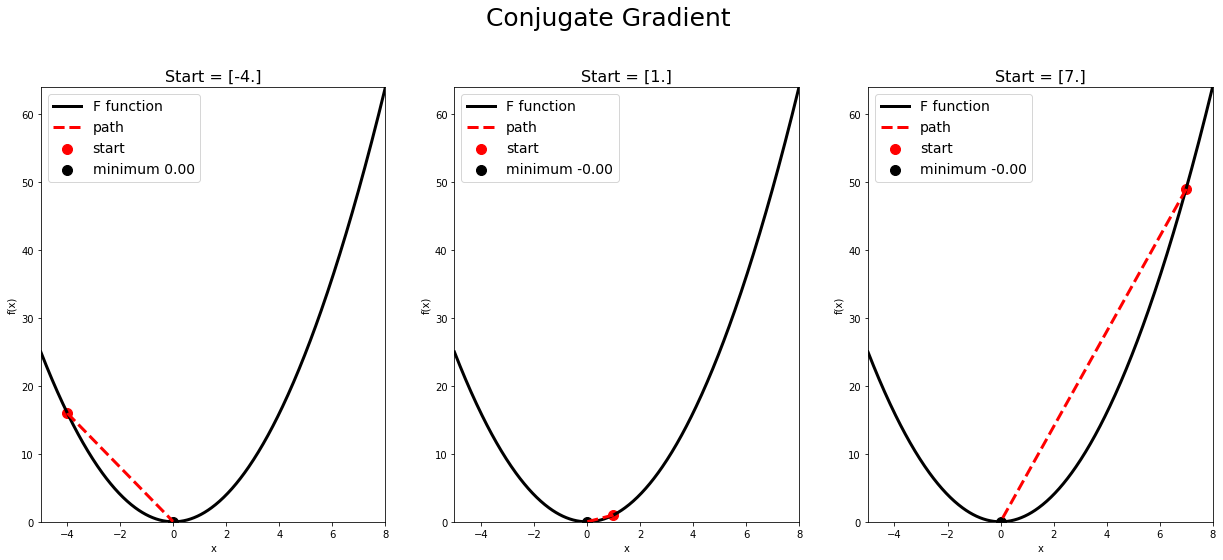

In [23]:
evaluate.plot_path(f0, res1['Conjugate Gradient'], 'Conjugate Gradient', dim=1,x_grid=x_grid0)

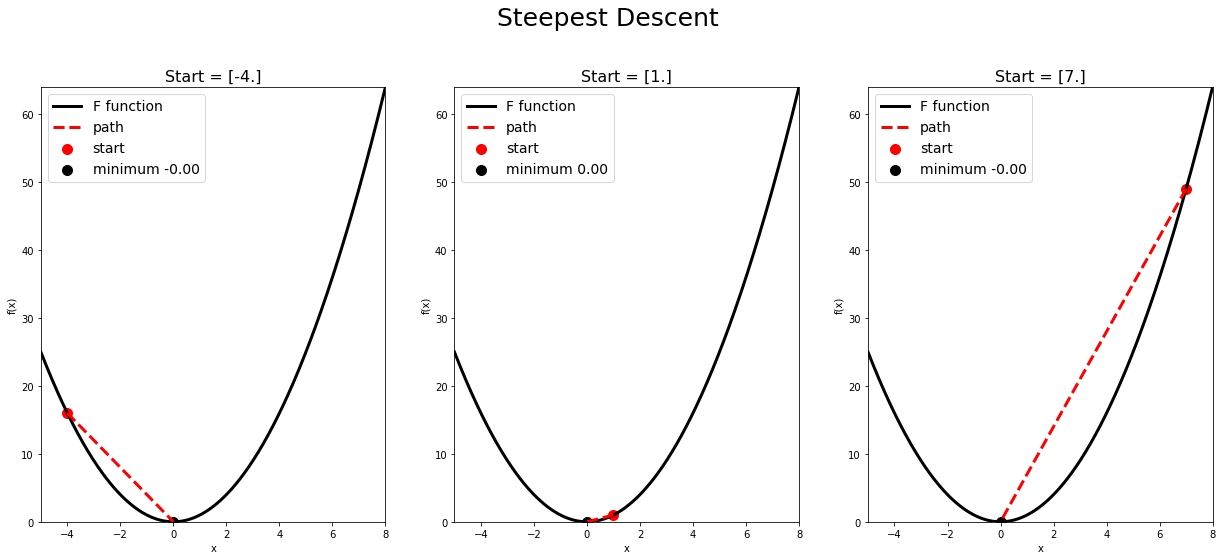

In [24]:
evaluate.plot_path(f0, res1['Steepest Descent'], 'Steepest Descent', dim=1,x_grid=x_grid0)

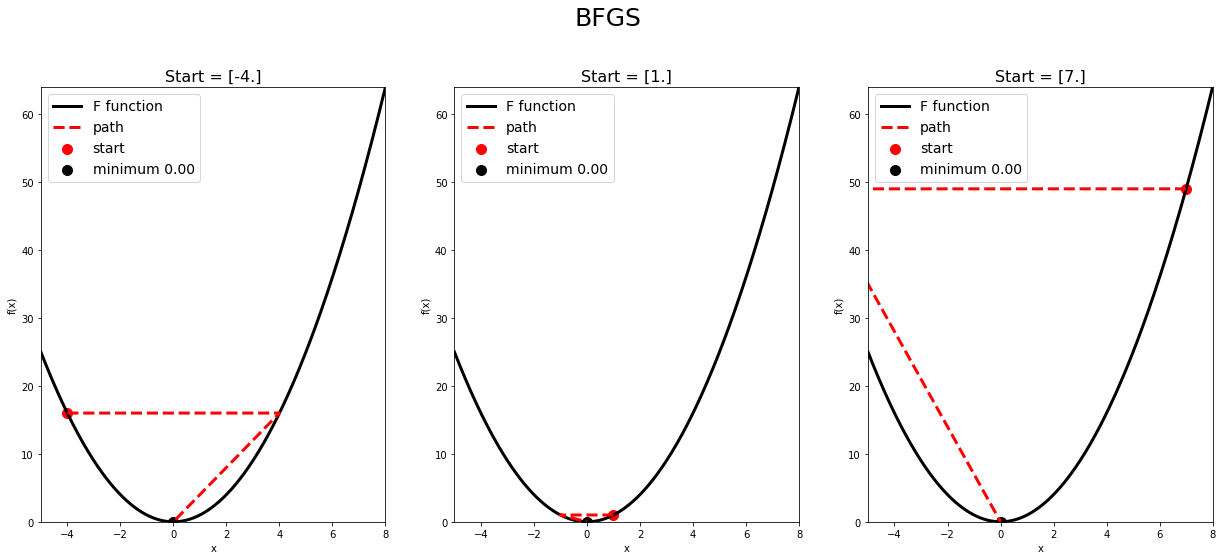

In [25]:
evaluate.plot_path(f0, res1['BFGS'], 'BFGS', dim=1,x_grid=x_grid0)

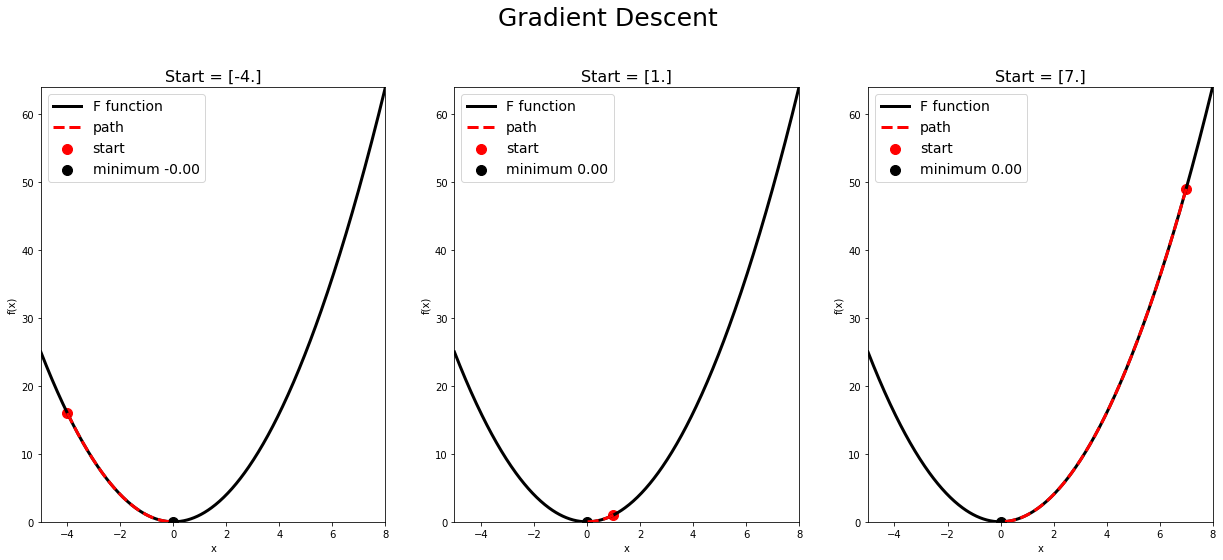

In [26]:
evaluate.plot_path(f0, res1['Gradient Descent'], 'Gradient Descent', dim=1,x_grid=x_grid0)

### Stochastic Gradient Descent

When one is optimizing a function over large datasets, it can be costly to compute the gradient over all the data (even with automatic differentiation). Instead, one can evaluate the function for one datapoint at a time and make gradient descent updates for each evaluation. In the long run, this approximates gradient descent.

One can implement linear regression with our automatic differentiation package as follows:

1. Get data.

In [12]:
indep_var = np.random.normal(size = (100,2))
data = pd.DataFrame(data = indep_var, columns = ['indep_var1','indep_var2'])
data['dep_var'] = 2*data.indep_var1 + 3*data.indep_var2+np.random.normal(loc = 0, scale = 2, size=(len(data)))
data.head()

,indep_var1,indep_var2,dep_var
0,-0.022755,-1.955844,-5.491880
1,1.115004,0.179297,3.795530
2,-0.295631,-0.967954,-1.128704
3,1.439141,0.092116,-0.777908
4,-0.390532,-1.086842,-7.193565


2. Extend `Model` class (access data with `self.data`)

In [13]:
class MSE_Regression(op.Model):
    def predict(self, beta1, beta2):
        return self.data['indep_var1']*beta1 + self.data['indep_var2']*beta2
    
    def loss(self, beta1, beta2):
        prediction = self.predict(beta1, beta2)
        return np.sum((prediction-self.data['dep_var'])**2)

3. Instantiate the `Model` object with data

In [14]:
model = MSE_Regression(data)

4. Call `minimize_over_data`.

In [17]:
r = op.minimize_over_data(model, [10,10], 'Gradient Descend', 40, stochastic = True, lr = 1e-3)
r.x

array([2.26279033, 2.82022594])

Text(0.5,1,'Stochastic Gradient Descent through Parameter Space')

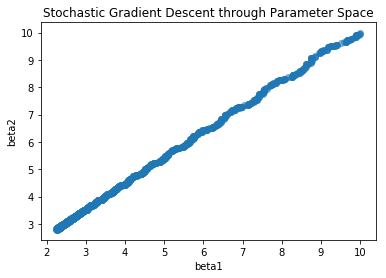

In [19]:
plt.scatter(np.array(r.val_rec)[:,0],np.array(r.val_rec)[:,1], alpha = .5)
plt.xlabel('beta1')
plt.ylabel('beta2')
plt.title('Stochastic Gradient Descent through Parameter Space')

### Future Implementation

#### Matrix Calculation

1. Loss minimization for deep learning networks
2. The analysis of multivariate normal and elliptical contoured distributions
3. Mixture models, such as expecation-maximization algorithm

#### 2nd order derivatives

1. Allow users to extract the Hessian of the jacobian matrics
2. Quasi-Newton's method

### Thanks for your attention! Any Questions?